In [1]:
%load_ext autoreload
%autoreload 2
import sys

import pandas as pd

sys.path.append("../..")

from mlstm_kernels.utils.benchmark.plot_results import (
    plot_benchmark_result_table,
    create_runtime_bar_plot,
    rc_context_wrapper,
    select_columns,
    savefig,
)
from pathlib import Path
from plot_config import linestyle_mapping, style_dict
import pickle

In [2]:
def load_throughput_results_for_ctxes(path_template: str, ctxes: list[int]):
    results = {}
    for ctx in ctxes:
        path = Path(path_template.format(ctx=ctx))
        df = pd.read_csv(path).filter(regex=".*(batch_size|prefill|R--).*")
        results[ctx] = df
    return results

In [3]:
llama_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_19-44-48__throughput__forward_llama_v3/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192, 16384, 32768],
)

mamba_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_13-02-27__throughput__forward_mamba_v2/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192, 16384, 32768],
)

mxlstm_results = load_throughput_results_for_ctxes(
    path_template="/home/beck/wdir/dev_repos/mlstm_kernels/outputs_kernel_benchmarks_final/2024-12-06_12-46-45__throughput__forward_xlstm_v0/hf_7B_throughput__pfl{ctx}_gl0_tcTrue_weightdtypebfloat16/results.csv",
    ctxes=[2048, 4096, 8192, 16384, 32768],
)

In [4]:
mamba_results[2048]

,P--prefill_length,P--batch_size,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,2048,1,72.727154,112.408176
1,2048,4,290.252129,487.798592
2,2048,8,582.758759,976.510025
3,2048,16,1184.665649,1934.497314
4,2048,32,2403.081787,3882.850830


In [5]:
llama_results[2048]

,P--prefill_length,P--batch_size,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False
0,2048,1,47.332440,52.418256
1,2048,2,91.504448,103.846966
2,2048,4,191.143909,215.597393
3,2048,8,379.785248,426.422531
4,2048,16,762.409790,869.689636
5,2048,32,1538.071442,1736.462799
6,2048,64,NaN,NaN


In [6]:
# collect all results sorted by context
result_dicts = [
    llama_results,
    mamba_results,
    mxlstm_results,
]
combined_raw_data = {}
for ctx in [2048, 4096, 8192, 16384, 32768]:
    ctx_df = pd.concat(
        [rd[ctx].set_index("P--batch_size") for rd in result_dicts], axis=1
    )
    # select batch size only once
    ctx_df = pd.concat(
        [
            ctx_df.filter(regex="prefill").take([0], axis=1),
            ctx_df.filter(regex=".*R--.*"),
        ],
        axis=1,
    )
    combined_raw_data[ctx] = ctx_df

In [7]:
combined_raw_data[2048].index.values

array([  1,   2,   4,   8,  16,  32,  64, 128])

In [8]:
with open("throughput_data.p", "wb") as f:
    pickle.dump(combined_raw_data, f)

for k, v in combined_raw_data.items():
    v.to_csv(f"raw_data_throughput_{k}.csv")

In [9]:
with open("throughput_data.p", "rb") as f:
    combined_raw_data = pickle.load(f)

In [10]:
2048 * combined_raw_data[2048].index.values

array([  2048,   4096,   8192,  16384,  32768,  65536, 131072, 262144])

In [11]:
vals = (2048 * combined_raw_data[2048].index.values)[:, None] / combined_raw_data[
    2048
].filter(regex=".*R--.*")
vals

,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,
1,43.268422,39.070358,28.160046,18.219315,45.366865
2,44.762851,39.442655,NaN,NaN,NaN
4,42.857761,37.996749,28.223738,16.793816,46.438266
8,43.140170,38.421985,28.114550,16.778118,47.391694
16,42.979511,37.677809,27.660125,16.938767,47.879745
32,42.609204,37.741091,27.271648,16.878320,47.580028
64,NaN,NaN,NaN,NaN,NaN
128,NaN,NaN,NaN,NaN,NaN


In [12]:
pd.DataFrame(
    data=vals,
    columns=combined_raw_data[2048].filter(regex=".*R--.*").columns,
    index=combined_raw_data[2048].index,
)

,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,
1,43.268422,39.070358,28.160046,18.219315,45.366865
2,44.762851,39.442655,NaN,NaN,NaN
4,42.857761,37.996749,28.223738,16.793816,46.438266
8,43.140170,38.421985,28.114550,16.778118,47.391694
16,42.979511,37.677809,27.660125,16.938767,47.879745
32,42.609204,37.741091,27.271648,16.878320,47.580028
64,NaN,NaN,NaN,NaN,NaN
128,NaN,NaN,NaN,NaN,NaN


In [13]:
combined_raw_data[2048]["P--prefill_length"].values[0]

2048.0

In [14]:
def compute_throughput_tokens_per_sec(raw_data_dict: dict[str, pd.DataFrame]):
    throughput_dict = {}
    for ctx, df in raw_data_dict.items():
        prefill_col = df.filter(regex="prefill").take([0], axis=1)
        tokens_per_sec_df = (ctx * df.index.values)[:, None] / (
            df.filter(regex=".*R--.*") / 1000
        )
        tokens_per_sec_df["P--prefill_length"] = int(prefill_col.values[0].item())
        # now make index a column again
        batch_col = tokens_per_sec_df.index
        tokens_per_sec_df["P--batch_size"] = batch_col

        tokens_per_sec_df = pd.concat(
            [
                tokens_per_sec_df["P--batch_size"],
                tokens_per_sec_df["P--prefill_length"],
                tokens_per_sec_df.drop(columns=["P--batch_size", "P--prefill_length"]),
            ],
            axis=1,
        )
        throughput_dict[ctx] = tokens_per_sec_df
    return throughput_dict

In [15]:
throughput_data = compute_throughput_tokens_per_sec(combined_raw_data)

In [16]:
throughput_data[2048]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
1,1,2048,43268.421905,39070.357617,28160.046057,18219.315224,45366.864888
2,2,2048,44762.851341,39442.654572,NaN,NaN,NaN
4,4,2048,42857.761063,37996.748869,28223.737891,16793.816425,46438.265959
8,8,2048,43140.169595,38421.984778,28114.549562,16778.117562,47391.693553
16,16,2048,42979.511056,37677.808996,27660.125046,16938.767377,47879.744963
32,32,2048,42609.204115,37741.090702,27271.647745,16878.320303,47580.028067
64,64,2048,NaN,NaN,NaN,NaN,NaN
128,128,2048,NaN,NaN,NaN,NaN,NaN


In [17]:
throughput_data[4096]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
1,1,4096,42848.982137,37977.285679,28590.497929,18886.093571,46417.329706
2,2,4096,41948.037715,37001.546358,NaN,NaN,NaN
4,4,4096,41570.430107,36999.828257,27911.938548,16829.880641,47279.327491
8,8,4096,41175.015780,36326.226990,27585.127620,16873.206088,47952.123878
16,16,4096,40829.126532,36342.862547,27183.777762,16839.658242,47542.531585
32,32,4096,NaN,NaN,NaN,NaN,NaN
64,64,4096,NaN,NaN,NaN,NaN,NaN
128,128,4096,NaN,NaN,NaN,NaN,NaN


In [18]:
throughput_data[8192]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
1,1,8192,38494.153325,34237.030113,28426.926847,18104.708992,46283.343723
2,2,8192,39020.934459,34781.395733,NaN,NaN,NaN
4,4,8192,38471.724294,34166.171971,27700.586511,16303.002665,47957.827341
8,8,8192,37863.720354,33938.074356,27354.375570,16448.514036,47627.074616
16,16,8192,NaN,NaN,NaN,NaN,NaN
32,32,8192,NaN,NaN,NaN,NaN,NaN
64,64,8192,NaN,NaN,NaN,NaN,NaN
128,128,8192,NaN,NaN,NaN,NaN,NaN


In [19]:
throughput_data[16384]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
1,1,16384,33622.367570,30537.334739,28288.303517,18286.463866,47676.759808
2,2,16384,33205.432014,30043.477937,28198.576002,16210.222193,48103.276135
4,4,16384,33210.548703,29999.962393,28013.662266,16308.684318,47595.969620
8,8,16384,NaN,NaN,NaN,NaN,NaN
16,16,16384,NaN,NaN,NaN,NaN,NaN
32,32,16384,NaN,NaN,NaN,NaN,NaN
64,64,16384,NaN,NaN,NaN,NaN,NaN


In [20]:
throughput_data[32768]

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
1,1,32768,26310.012100,24394.353153,28330.467346,18333.455683,48042.544967
2,2,32768,26223.974696,24320.276207,28108.125235,16026.531272,47642.253932
4,4,32768,NaN,NaN,NaN,NaN,NaN
8,8,32768,NaN,NaN,NaN,NaN,NaN
16,16,32768,NaN,NaN,NaN,NaN,NaN
32,32,32768,NaN,NaN,NaN,NaN,NaN
64,64,32768,NaN,NaN,NaN,NaN,NaN


In [21]:
throughput_32768 = throughput_data[32768].loc[
    throughput_data[32768]["P--batch_size"] == 2.0
]
throughput_16384 = throughput_data[16384].loc[
    throughput_data[16384]["P--batch_size"] == 4.0
]
throughput_8192 = throughput_data[8192].loc[
    throughput_data[8192]["P--batch_size"] == 8.0
]
throughput_4096 = throughput_data[4096].loc[
    throughput_data[4096]["P--batch_size"] == 16.0
]
throughput_2048 = throughput_data[2048].loc[
    throughput_data[2048]["P--batch_size"] == 32.0
]

In [22]:
throughput_df = pd.concat(
    [
        throughput_2048,
        throughput_4096,
        throughput_8192,
        throughput_16384,
        throughput_32768,
    ]
)

In [23]:
throughput_df

,P--batch_size,P--prefill_length,R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False,R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16
P--batch_size,,,,,,,
32,32,2048,42609.204115,37741.090702,27271.647745,16878.320303,47580.028067
16,16,4096,40829.126532,36342.862547,27183.777762,16839.658242,47542.531585
8,8,8192,37863.720354,33938.074356,27354.375570,16448.514036,47627.074616
4,4,16384,33210.548703,29999.962393,28013.662266,16308.684318,47595.969620
2,2,32768,26223.974696,24320.276207,28108.125235,16026.531272,47642.253932


## Plotting the raw data

In [24]:
column_name_mapping = {
    "P--batch_size": "BS",
    "P--prefill_length": "CTX",
    "R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False": "llama2",
    "R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False": "llama3",
    "R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False": "codestral_mamba",
    "R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False": "falcon_mamba",
    "R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16": "xlstm",
}

In [25]:
throughput_df.columns

Index(['P--batch_size', 'P--prefill_length',
       'R--llama2__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False',
       'R--llama3__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False',
       'R--codestral_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False',
       'R--falcon_mamba__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False',
       'R--xlstm__tcm__ampdt-bfloat16__wdt-bfloat16__ucgg-True_ucgm-False_isd-bfloat16_ed-4096_nh-8_nb-32_vs-50304_wm-fused_ck-chunkwise--triton_xl_chunk_sk-native_sequence__triton_step_fused_sk-triton_fused_cs-128_akd-bfloat16'],
      dtype='object')

In [26]:
new_col_names = [column_name_mapping.get(col, col) for col in throughput_df.columns]
throughput_df.columns = new_col_names

In [27]:
plot_throughput_df = throughput_df.round(0).astype(int)
plot_throughput_df

,BS,CTX,llama2,llama3,codestral_mamba,falcon_mamba,xlstm
P--batch_size,,,,,,,
32,32,2048,42609,37741,27272,16878,47580
16,16,4096,40829,36343,27184,16840,47543
8,8,8192,37864,33938,27354,16449,47627
4,4,16384,33211,30000,28014,16309,47596
2,2,32768,26224,24320,28108,16027,47642


In [29]:
fig = rc_context_wrapper(
    func=create_runtime_bar_plot,
    data_df=plot_throughput_df,
    group_col_names=["BS", "CTX"],
    style_dict=style_dict,
    figsize=(2 * 12 * 1 / 2.54, 1.5 * 8 * 1 / 2.54),
    y_label="Tokens per Second",
)

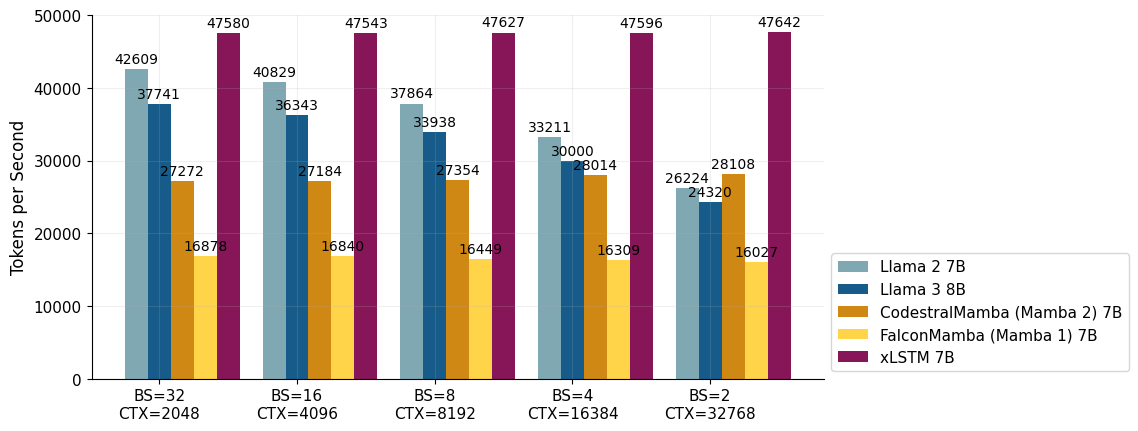

In [30]:
fig

In [31]:
savefig(fig, "throughput")